# FGSM Attack Demo
This notebook demonstrates the Fast Gradient Sign Method (FGSM) adversarial attack on a simple image classification model (e.g., MNIST).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0
x_test = np.expand_dims(x_test, -1)

# Build a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train on a small subset for speed
model.fit(x_train[:10000].reshape(-1,28,28,1)/255.0, y_train[:10000], epochs=3, validation_split=0.1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


c:\Users\Seanw\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7510 - loss: 0.8449 - val_accuracy: 0.9280 - val_loss: 0.2232
Epoch 2/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9563 - loss: 0.1553 - val_accuracy: 0.9640 - val_loss: 0.1204
Epoch 3/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9710 - loss: 0.0968 - val_accuracy: 0.9690 - val_loss: 0.1110


In [5]:
# Define FGSM attack
def fgsm_attack(image, label, epsilon=0.1):
    image = tf.convert_to_tensor(image[None, ...])
    label = tf.convert_to_tensor([label])

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    return tf.clip_by_value(adversarial_image, 0, 1).numpy()[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


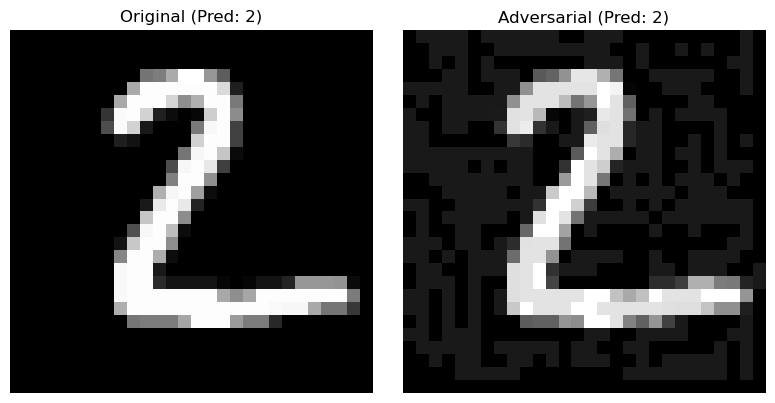

In [6]:
# Select one sample to attack
sample_index = 1
image = x_test[sample_index]
label = y_test[sample_index]

# Run attack
adv_image = fgsm_attack(image, label)

# Predict on original and adversarial images
pred_orig = model.predict(image[None, ...]).argmax()
pred_adv = model.predict(adv_image[None, ...]).argmax()

# Display results
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"Original (Pred: {pred_orig})")
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f"Adversarial (Pred: {pred_adv})")
plt.imshow(adv_image.squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
